# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


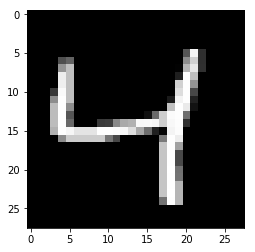

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [24]:
learning_rate = 0.001
# Input and target 

inputs_ = tf.placeholder(tf.float32, shape = (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, shape = (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='SAME', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [25]:
sess = tf.Session()

In [26]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6959
Epoch: 1/20... Training loss: 0.6921
Epoch: 1/20... Training loss: 0.6887
Epoch: 1/20... Training loss: 0.6852
Epoch: 1/20... Training loss: 0.6812
Epoch: 1/20... Training loss: 0.6764
Epoch: 1/20... Training loss: 0.6706
Epoch: 1/20... Training loss: 0.6639
Epoch: 1/20... Training loss: 0.6547
Epoch: 1/20... Training loss: 0.6445
Epoch: 1/20... Training loss: 0.6318
Epoch: 1/20... Training loss: 0.6183
Epoch: 1/20... Training loss: 0.6010
Epoch: 1/20... Training loss: 0.5823
Epoch: 1/20... Training loss: 0.5643
Epoch: 1/20... Training loss: 0.5449
Epoch: 1/20... Training loss: 0.5275
Epoch: 1/20... Training loss: 0.5135
Epoch: 1/20... Training loss: 0.5048
Epoch: 1/20... Training loss: 0.5052
Epoch: 1/20... Training loss: 0.5117
Epoch: 1/20... Training loss: 0.5116
Epoch: 1/20... Training loss: 0.5148
Epoch: 1/20... Training loss: 0.4985
Epoch: 1/20... Training loss: 0.4731
Epoch: 1/20... Training loss: 0.4731
Epoch: 1/20... Training loss: 0.4704
E

Epoch: 1/20... Training loss: 0.1556
Epoch: 1/20... Training loss: 0.1604
Epoch: 1/20... Training loss: 0.1581
Epoch: 1/20... Training loss: 0.1541
Epoch: 1/20... Training loss: 0.1589
Epoch: 1/20... Training loss: 0.1502
Epoch: 1/20... Training loss: 0.1501
Epoch: 1/20... Training loss: 0.1541
Epoch: 1/20... Training loss: 0.1528
Epoch: 1/20... Training loss: 0.1563
Epoch: 1/20... Training loss: 0.1600
Epoch: 1/20... Training loss: 0.1551
Epoch: 1/20... Training loss: 0.1526
Epoch: 1/20... Training loss: 0.1574
Epoch: 1/20... Training loss: 0.1580
Epoch: 1/20... Training loss: 0.1483
Epoch: 1/20... Training loss: 0.1544
Epoch: 1/20... Training loss: 0.1539
Epoch: 1/20... Training loss: 0.1532
Epoch: 1/20... Training loss: 0.1544
Epoch: 1/20... Training loss: 0.1529
Epoch: 1/20... Training loss: 0.1548
Epoch: 1/20... Training loss: 0.1605
Epoch: 1/20... Training loss: 0.1499
Epoch: 1/20... Training loss: 0.1521
Epoch: 1/20... Training loss: 0.1547
Epoch: 1/20... Training loss: 0.1548
E

Epoch: 2/20... Training loss: 0.1282
Epoch: 2/20... Training loss: 0.1292
Epoch: 2/20... Training loss: 0.1357
Epoch: 2/20... Training loss: 0.1318
Epoch: 2/20... Training loss: 0.1346
Epoch: 2/20... Training loss: 0.1343
Epoch: 2/20... Training loss: 0.1363
Epoch: 2/20... Training loss: 0.1369
Epoch: 2/20... Training loss: 0.1311
Epoch: 2/20... Training loss: 0.1340
Epoch: 2/20... Training loss: 0.1334
Epoch: 2/20... Training loss: 0.1327
Epoch: 2/20... Training loss: 0.1339
Epoch: 2/20... Training loss: 0.1368
Epoch: 2/20... Training loss: 0.1364
Epoch: 2/20... Training loss: 0.1363
Epoch: 2/20... Training loss: 0.1332
Epoch: 2/20... Training loss: 0.1354
Epoch: 2/20... Training loss: 0.1305
Epoch: 2/20... Training loss: 0.1334
Epoch: 2/20... Training loss: 0.1302
Epoch: 2/20... Training loss: 0.1328
Epoch: 2/20... Training loss: 0.1347
Epoch: 2/20... Training loss: 0.1329
Epoch: 2/20... Training loss: 0.1344
Epoch: 2/20... Training loss: 0.1320
Epoch: 2/20... Training loss: 0.1309
E

Epoch: 3/20... Training loss: 0.1304
Epoch: 3/20... Training loss: 0.1194
Epoch: 3/20... Training loss: 0.1264
Epoch: 3/20... Training loss: 0.1227
Epoch: 3/20... Training loss: 0.1268
Epoch: 3/20... Training loss: 0.1233
Epoch: 3/20... Training loss: 0.1244
Epoch: 3/20... Training loss: 0.1225
Epoch: 3/20... Training loss: 0.1259
Epoch: 3/20... Training loss: 0.1253
Epoch: 3/20... Training loss: 0.1245
Epoch: 3/20... Training loss: 0.1254
Epoch: 3/20... Training loss: 0.1271
Epoch: 3/20... Training loss: 0.1216
Epoch: 3/20... Training loss: 0.1283
Epoch: 3/20... Training loss: 0.1298
Epoch: 3/20... Training loss: 0.1201
Epoch: 3/20... Training loss: 0.1234
Epoch: 3/20... Training loss: 0.1235
Epoch: 3/20... Training loss: 0.1242
Epoch: 3/20... Training loss: 0.1242
Epoch: 3/20... Training loss: 0.1216
Epoch: 3/20... Training loss: 0.1229
Epoch: 3/20... Training loss: 0.1271
Epoch: 3/20... Training loss: 0.1220
Epoch: 3/20... Training loss: 0.1238
Epoch: 3/20... Training loss: 0.1249
E

Epoch: 3/20... Training loss: 0.1175
Epoch: 3/20... Training loss: 0.1224
Epoch: 3/20... Training loss: 0.1152
Epoch: 3/20... Training loss: 0.1173
Epoch: 3/20... Training loss: 0.1171
Epoch: 3/20... Training loss: 0.1219
Epoch: 3/20... Training loss: 0.1175
Epoch: 3/20... Training loss: 0.1188
Epoch: 3/20... Training loss: 0.1152
Epoch: 3/20... Training loss: 0.1214
Epoch: 3/20... Training loss: 0.1176
Epoch: 3/20... Training loss: 0.1150
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1130
Epoch: 4/20... Training loss: 0.1169
Epoch: 4/20... Training loss: 0.1210
Epoch: 4/20... Training loss: 0.1211
Epoch: 4/20... Training loss: 0.1207
Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1155
Epoch: 4/20... Training loss: 0.1212
Epoch: 4/20... Training loss: 0.1207
Epoch: 4/20... Training loss: 0.1166
Epoch: 4/20... Training loss: 0.1192
Epoch: 4/20... Training loss: 0.1193
E

Epoch: 4/20... Training loss: 0.1158
Epoch: 4/20... Training loss: 0.1106
Epoch: 4/20... Training loss: 0.1178
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1193
Epoch: 4/20... Training loss: 0.1096
Epoch: 4/20... Training loss: 0.1143
Epoch: 4/20... Training loss: 0.1125
Epoch: 4/20... Training loss: 0.1133
Epoch: 4/20... Training loss: 0.1191
Epoch: 4/20... Training loss: 0.1101
Epoch: 4/20... Training loss: 0.1140
Epoch: 4/20... Training loss: 0.1137
Epoch: 4/20... Training loss: 0.1142
Epoch: 4/20... Training loss: 0.1090
Epoch: 4/20... Training loss: 0.1083
Epoch: 4/20... Training loss: 0.1161
Epoch: 4/20... Training loss: 0.1135
Epoch: 4/20... Training loss: 0.1121
Epoch: 4/20... Training loss: 0.1164
Epoch: 4/20... Training loss: 0.1113
Epoch: 4/20... Training loss: 0.1151
Epoch: 4/20... Training loss: 0.1138
Epoch: 4/20... Training loss: 0.1184
Epoch: 4/20... Training loss: 0.1169
Epoch: 4/20... Training loss: 0.1168
Epoch: 4/20... Training loss: 0.1126
E

Epoch: 5/20... Training loss: 0.1124
Epoch: 5/20... Training loss: 0.1163
Epoch: 5/20... Training loss: 0.1093
Epoch: 5/20... Training loss: 0.1097
Epoch: 5/20... Training loss: 0.1149
Epoch: 5/20... Training loss: 0.1104
Epoch: 5/20... Training loss: 0.1064
Epoch: 5/20... Training loss: 0.1084
Epoch: 5/20... Training loss: 0.1126
Epoch: 5/20... Training loss: 0.1099
Epoch: 5/20... Training loss: 0.1138
Epoch: 5/20... Training loss: 0.1114
Epoch: 5/20... Training loss: 0.1144
Epoch: 5/20... Training loss: 0.1114
Epoch: 5/20... Training loss: 0.1126
Epoch: 5/20... Training loss: 0.1086
Epoch: 5/20... Training loss: 0.1107
Epoch: 5/20... Training loss: 0.1110
Epoch: 5/20... Training loss: 0.1154
Epoch: 5/20... Training loss: 0.1116
Epoch: 5/20... Training loss: 0.1146
Epoch: 5/20... Training loss: 0.1128
Epoch: 5/20... Training loss: 0.1105
Epoch: 5/20... Training loss: 0.1114
Epoch: 5/20... Training loss: 0.1087
Epoch: 5/20... Training loss: 0.1052
Epoch: 5/20... Training loss: 0.1113
E

Epoch: 6/20... Training loss: 0.1082
Epoch: 6/20... Training loss: 0.1123
Epoch: 6/20... Training loss: 0.1082
Epoch: 6/20... Training loss: 0.1093
Epoch: 6/20... Training loss: 0.1086
Epoch: 6/20... Training loss: 0.1075
Epoch: 6/20... Training loss: 0.1131
Epoch: 6/20... Training loss: 0.1055
Epoch: 6/20... Training loss: 0.1123
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1104
Epoch: 6/20... Training loss: 0.1082
Epoch: 6/20... Training loss: 0.1125
Epoch: 6/20... Training loss: 0.1087
Epoch: 6/20... Training loss: 0.1105
Epoch: 6/20... Training loss: 0.1056
Epoch: 6/20... Training loss: 0.1066
Epoch: 6/20... Training loss: 0.1077
Epoch: 6/20... Training loss: 0.1049
Epoch: 6/20... Training loss: 0.1092
Epoch: 6/20... Training loss: 0.1088
Epoch: 6/20... Training loss: 0.1117
Epoch: 6/20... Training loss: 0.1064
Epoch: 6/20... Training loss: 0.1101
Epoch: 6/20... Training loss: 0.1075
Epoch: 6/20... Training loss: 0.1077
Epoch: 6/20... Training loss: 0.1077
E

Epoch: 6/20... Training loss: 0.1080
Epoch: 6/20... Training loss: 0.1076
Epoch: 6/20... Training loss: 0.1085
Epoch: 6/20... Training loss: 0.1070
Epoch: 6/20... Training loss: 0.1057
Epoch: 6/20... Training loss: 0.1129
Epoch: 6/20... Training loss: 0.1075
Epoch: 6/20... Training loss: 0.1101
Epoch: 6/20... Training loss: 0.1070
Epoch: 6/20... Training loss: 0.1062
Epoch: 6/20... Training loss: 0.1057
Epoch: 6/20... Training loss: 0.1077
Epoch: 6/20... Training loss: 0.1046
Epoch: 6/20... Training loss: 0.1011
Epoch: 6/20... Training loss: 0.1100
Epoch: 6/20... Training loss: 0.1092
Epoch: 6/20... Training loss: 0.1068
Epoch: 6/20... Training loss: 0.1062
Epoch: 6/20... Training loss: 0.1035
Epoch: 6/20... Training loss: 0.1091
Epoch: 6/20... Training loss: 0.1047
Epoch: 6/20... Training loss: 0.1095
Epoch: 6/20... Training loss: 0.1049
Epoch: 6/20... Training loss: 0.1068
Epoch: 7/20... Training loss: 0.1068
Epoch: 7/20... Training loss: 0.1077
Epoch: 7/20... Training loss: 0.1110
E

Epoch: 7/20... Training loss: 0.1051
Epoch: 7/20... Training loss: 0.1062
Epoch: 7/20... Training loss: 0.1083
Epoch: 7/20... Training loss: 0.1062
Epoch: 7/20... Training loss: 0.1072
Epoch: 7/20... Training loss: 0.1069
Epoch: 7/20... Training loss: 0.1039
Epoch: 7/20... Training loss: 0.1117
Epoch: 7/20... Training loss: 0.1075
Epoch: 7/20... Training loss: 0.1076
Epoch: 7/20... Training loss: 0.1035
Epoch: 7/20... Training loss: 0.1070
Epoch: 7/20... Training loss: 0.1028
Epoch: 7/20... Training loss: 0.1065
Epoch: 7/20... Training loss: 0.1076
Epoch: 7/20... Training loss: 0.1046
Epoch: 7/20... Training loss: 0.1102
Epoch: 7/20... Training loss: 0.1043
Epoch: 7/20... Training loss: 0.1059
Epoch: 7/20... Training loss: 0.1063
Epoch: 7/20... Training loss: 0.1044
Epoch: 7/20... Training loss: 0.1073
Epoch: 7/20... Training loss: 0.1081
Epoch: 7/20... Training loss: 0.1131
Epoch: 7/20... Training loss: 0.1032
Epoch: 7/20... Training loss: 0.1072
Epoch: 7/20... Training loss: 0.1054
E

Epoch: 8/20... Training loss: 0.1047
Epoch: 8/20... Training loss: 0.1086
Epoch: 8/20... Training loss: 0.1043
Epoch: 8/20... Training loss: 0.1034
Epoch: 8/20... Training loss: 0.1029
Epoch: 8/20... Training loss: 0.1023
Epoch: 8/20... Training loss: 0.1061
Epoch: 8/20... Training loss: 0.1036
Epoch: 8/20... Training loss: 0.1066
Epoch: 8/20... Training loss: 0.1046
Epoch: 8/20... Training loss: 0.1008
Epoch: 8/20... Training loss: 0.1054
Epoch: 8/20... Training loss: 0.1065
Epoch: 8/20... Training loss: 0.1037
Epoch: 8/20... Training loss: 0.1057
Epoch: 8/20... Training loss: 0.1056
Epoch: 8/20... Training loss: 0.1072
Epoch: 8/20... Training loss: 0.1055
Epoch: 8/20... Training loss: 0.1061
Epoch: 8/20... Training loss: 0.1033
Epoch: 8/20... Training loss: 0.1063
Epoch: 8/20... Training loss: 0.1014
Epoch: 8/20... Training loss: 0.1041
Epoch: 8/20... Training loss: 0.1036
Epoch: 8/20... Training loss: 0.1062
Epoch: 8/20... Training loss: 0.1010
Epoch: 8/20... Training loss: 0.1048
E

Epoch: 9/20... Training loss: 0.1051
Epoch: 9/20... Training loss: 0.1042
Epoch: 9/20... Training loss: 0.1067
Epoch: 9/20... Training loss: 0.1060
Epoch: 9/20... Training loss: 0.1029
Epoch: 9/20... Training loss: 0.1025
Epoch: 9/20... Training loss: 0.1038
Epoch: 9/20... Training loss: 0.1047
Epoch: 9/20... Training loss: 0.1045
Epoch: 9/20... Training loss: 0.1035
Epoch: 9/20... Training loss: 0.1045
Epoch: 9/20... Training loss: 0.1014
Epoch: 9/20... Training loss: 0.1024
Epoch: 9/20... Training loss: 0.1052
Epoch: 9/20... Training loss: 0.1015
Epoch: 9/20... Training loss: 0.1050
Epoch: 9/20... Training loss: 0.1059
Epoch: 9/20... Training loss: 0.1030
Epoch: 9/20... Training loss: 0.1069
Epoch: 9/20... Training loss: 0.1050
Epoch: 9/20... Training loss: 0.1058
Epoch: 9/20... Training loss: 0.1045
Epoch: 9/20... Training loss: 0.1059
Epoch: 9/20... Training loss: 0.1066
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.1064
Epoch: 9/20... Training loss: 0.1047
E

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [ ]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [ ]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = 
# Now 28x28x32
maxpool1 = 
# Now 14x14x32
conv2 = 
# Now 14x14x32
maxpool2 = 
# Now 7x7x32
conv3 = 
# Now 7x7x16
encoded = 
# Now 4x4x16

### Decoder
upsample1 = 
# Now 7x7x16
conv4 = 
# Now 7x7x16
upsample2 = 
# Now 14x14x16
conv5 = 
# Now 14x14x32
upsample3 = 
# Now 28x28x32
conv6 = 
# Now 28x28x32

logits = 
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded =

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = 

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)